<a href="https://colab.research.google.com/github/davifcs/ia006/blob/master/Lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Bibliotecas 
O desenvolvimento do exerciício se deu na linguagem de programção Python e as bibliotecas utilizadas são as que seguem abaixo.

É importante evidenciar que nenhum pacote pronto para regressão logística e *k Nearst Neighbors* foi utilizado.


In [0]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]
import numpy as np
from numpy import linalg as la
import pandas as pd
from sklearn import metrics
import seaborn as sbn
from collections import Counter 

---


##Classificação Linear - Binária 

####Natureza dos dados
O conjunto de dados  para a atividade foram obtidos através do hiperlink compartilhado pelo professor.



In [0]:
df = pd.read_csv('http://www.dca.fee.unicamp.br/~lboccato/dados_voz_genero.csv')


Traçando a matriz de correlação entre cada um dos 19 atributos é possível perceber que o atributo identificado como **IQR** possue uma significante correlação positiva com o rótulo, essa sendo de 0,61,  enquanto por outro lado o atributo **meanfun** possue uma forte correlação negativa de -0,83. 

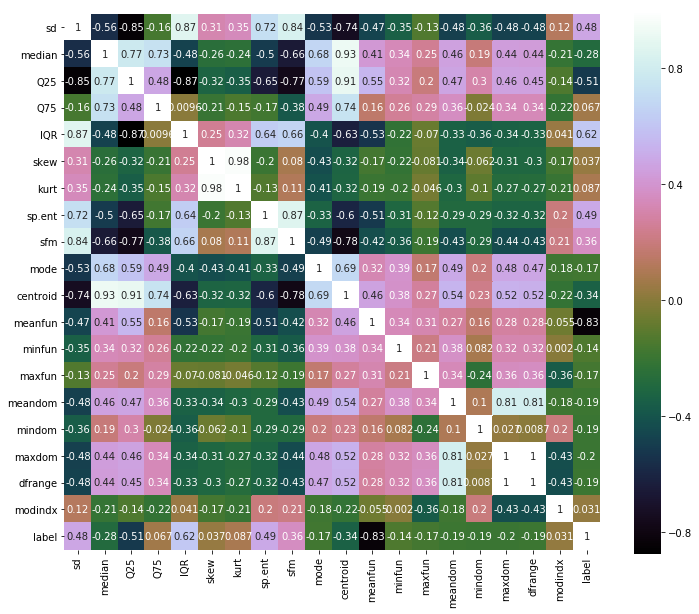

In [0]:
correlation = df.corr()  
plt.figure(figsize=(12,10))
corr = sbn.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')  

Observando o histograma construito para atributo **IQR** é possível notar que a distribuição de frequência não se comporta propriamente como uma distribuição normal, o que corrobora com sua relativamente alta correlação com o rótulo.
Por outro lado em seu histograma o atributo **meanfun** apresentação uma distribuição similar à normal o que vai ao encontro de sua baixa correlação com o rótulo. 

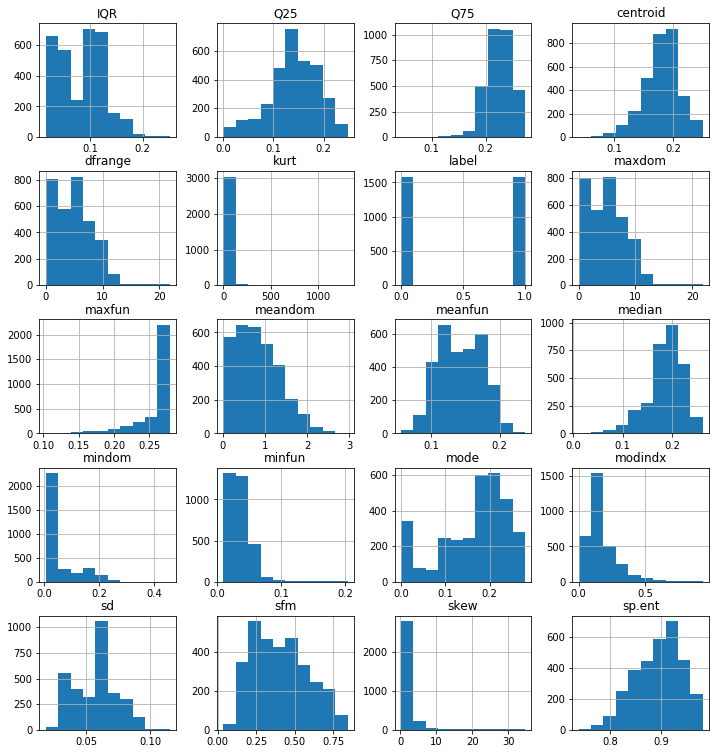

In [0]:
hist = df.hist(bins=10, figsize=(12,13))

*  Todos os 19 atributos foram utilizados para a realiazação da regreção.
*  Uma parcela de 10% das amostras de cada rótulo foi reservada para teste aleatoriamente.
*  Houve ajuste na escala das váriaveis de entrada por meio de um mapeamento linear.

In [0]:
label_0_df = df[df['label'] == 0.0].sample(frac=.1)
label_1_df = df[df['label'] == 1.0].sample(frac=.1)
label_df = [label_0_df, label_1_df]
test_df = pd.concat(label_df)
train_df = df.drop(test_df.index)

test_features_df = test_df.iloc[:, 0:18]
normalized_test_features_df=(test_features_df-test_features_df.min())/(test_features_df.max()-test_features_df.min())

train_features_df = train_df.iloc[:, 0:18]
normalized_train_features_df=(train_features_df-train_features_df.min())/(train_features_df.max()-train_features_df.min())


*  As implementações dos métodos para: Cálculo da função logística, custo,  treinamento, e teste, podem ser verificar no trecho de código a seguir.

In [0]:
def probability(X, theta):
    return sigmoid(np.dot(X,theta))

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(h, y):
  cost = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
  return cost






def train(X, y, theta, lr, i):
  cost_history = []

  for i in range(i):
    h = probability(X,theta)
    gradient = np.dot(X.T, (h - y)) / len(y)
    theta -= gradient * lr
    cost_history.append(cost(h,y))
  return theta, cost_history

def predict(X, theta, t=0):
  if(t != 0): 
    return (probability(X, theta) >= t)
  else:
    return probability(X, theta)

*  O algoritmo de classificação linear recebeu como parâmetros de entrada os valores de: 10^4 para iterações, 0,1 para taxa de aprendizagem. 
*  A função custo J(w) por número de iterações pode ser verificada a seguir.

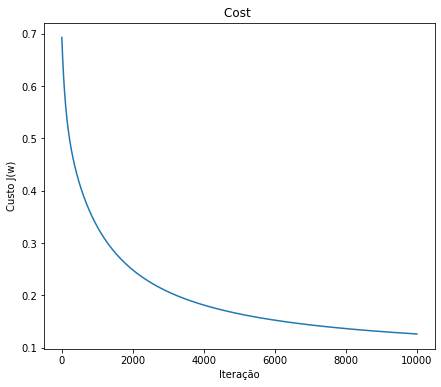

In [0]:
X = np.asarray(normalized_train_features_df)
y = np.asarray(train_df.iloc[:, 19])
theta = np.zeros(X.shape[1])
learning_rate = 0.1
iterations = 10000
theta, cost_history = train(X,y,theta,learning_rate, iterations)

plt.plot(cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo J(w)')
plt.title('Cost ')
plt.show()

*  Em posse do modelo treinado, o mesmo foi avaliado junto ao conjunto de teste.

A curva *Receiver Operating Characteristic* (ROC) foi traçada para o classificador e através dessa é possível perceber o desempenho satisfatório do classificador proposto, apresentando uma taxa de verdadeiro positivo muito próxima de 1.0 enquanto a taxa de falso positivo ainda é de aproximadamente 0,1.  


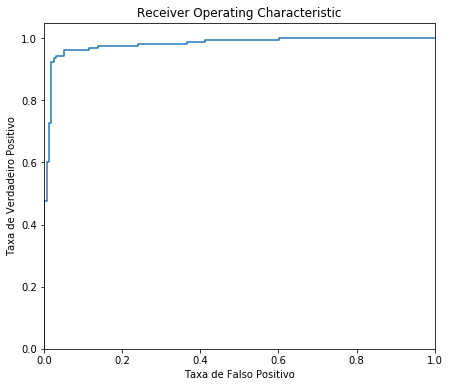

In [0]:
X = np.asarray(normalized_test_features_df)
y = np.asarray(test_df.iloc[:, 19])
p = predict(X, theta)

fpr, tpr, _ = metrics.roc_curve(y, p)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Receiver Operating Characteristic')
plt.show()

A evolução do F-Score a medida que o threshold é variado também foi investigada. Nessa curva é possível perceber que o F-Score apresenta um continuo aumento até uma subta queda com um threshold por volta de 0,85.

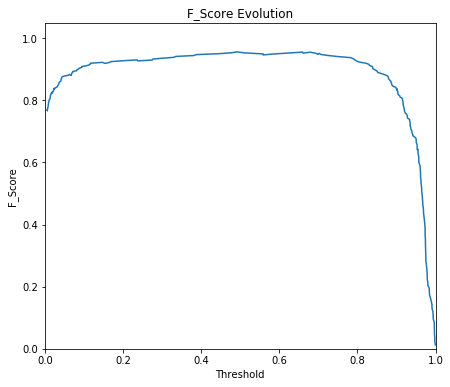

In [0]:
precision, recall, thresholds = metrics.precision_recall_curve(y, p)
precision = precision[:-1]
recall = recall[:-1]
f1_evolution = 2*(recall*precision)/(recall+precision)

plt.plot(thresholds, f1_evolution)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('F_Score')
plt.title('F_Score Evolution')
plt.show()

O valor de threshold que maximiza o F-Score foi de 0,576 enquanto o próprio valor de F-Score foi de 0,978. E analisando a matrix de confusão obtida é evidente que o classficador obteve sucesso em sua tarefa, já que falsos negativos e falsos positivos totalizam 1% e 3% respectivamente.


In [0]:
max_f1 = np.where(f1_evolution == max(f1_evolution))
threshold = thresholds[max_f1][0]
print("Threshold", threshold)

p_binary = (p >= threshold).astype(int)
print("F-Score", metrics.f1_score(y,p_binary))

conf_matrix = metrics.confusion_matrix(y, p_binary)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm = sbn.heatmap(conf_matrix, fmt='.2f', square=True, annot=True, cmap="Blues")




plt.xlabel('Classe Estimada')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.figure(figsize=(5,4))
plt.show()


---


##Classificação Linear - Multi-Classe 
*  O conjunto de dados para a atividade foi obtido em https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphon e então carregado no Notebook python.
* No total existem seis classes, sendo elas: 0 – caminhada; 1 – subindo escadas; 2 – descendo escadas; 3 – sentado; 4 – em pé; 5 – deitado.
*  Todos os 561 atributos foram utilizados para a realização da regreção.
*  Uma parcela de 40% das amostras foi reservada para teste.

In [0]:
train_X = pd.read_csv("/content/X_train.txt", delim_whitespace=True)
train_X = np.asarray(train_X)
train_y = pd.read_csv("/content/y_train.txt")
classes = train_y.drop_duplicates()
classes = classes.reset_index()
classes = classes.rename(columns={"index": "line", "5": "class"})
classes = classes['class'].values
train_y = np.asarray(train_y.T)
train_y = train_y[0]

test_X = pd.read_csv("/content/X_test.txt", delim_whitespace=True)
test_X = np.asarray(test_X)
test_y = pd.read_csv("/content/y_test.txt", delim_whitespace=True)
test_y = np.asarray(test_y.T)
test_y = test_y[0]

* Por conveniência ao fato de que na atividade anterior foram implementados métodos para cálculo de uma regressão linear do tipo binária, no cenário de multi-classes a abordagem escolhida foi a de um-contra-todos. 

>> A estratégia um-contra-todos envolve o treinamento de um único classificador por classe, sendo as amostras dessa classe tidas como amostras positivas e todas as outras como negativas. Tal estratégia necessita que as classificações resultem em um valor real e não somente um rótulo de classe. Decide-se como rótulo a classe referente ao classificador que possuir o máximo valor resultante.

* A implementação do algoritmo necessário para o cenário multi-classe pode ser conferida a seguir
* O algoritmo de classificação linear recebeu como parâmetros de entrada os valores de: 10^4 para iterações, 0.1 para taxa de aprendizagem. 

In [0]:
q_theta = []
q_cost_history = []
learning_rate = 0.1
iterations = 10000
X = train_X

for q in classes:
  theta = np.zeros(train_X.shape[1])
  y = np.where(train_y != q, 0, train_y) 
  y = np.where(train_y == q, 1, y)
  theta, cost_history = train(X,y,theta,learning_rate, iterations)
  q_theta.append(theta)
  q_cost_history.append(cost_history)
  

* Em posse do modelo treinado foi então avaliado seu desempenho junto ao conjunto de teste.

Para a avaliação global do modelo o critério adotado foi de *micro-averaging*, já que o conjunto de dados apresenta uma diferença de mais de 100 amostras entre a classe com mais e menos amostras, como pode ser verificado a seguir. 



In [0]:
Counter(test_y).most_common()

[(6, 537), (5, 531), (1, 496), (4, 491), (2, 471), (3, 420)]

O critério escolhido soma de forma cumulativa os indicadores, verdadeiro positivo, falso negativo, verdadeiro negativo, e falso positivo e então calcula a perfomance do modelo, evidenciando assim possíveis desbalanceamentos entre classes (M. SOKOLOVA & G. LAPALME, 2009).

Sendo assim, o F-score atingiu o valor de 0,956, analisando a matriz de confusão é possível perceber que o classificador que apresentou maiores problemas foi o referente a classe 3, já que identificou 11% das amostras erronemante como classe 4. 

F-Score 0.9562118126272913


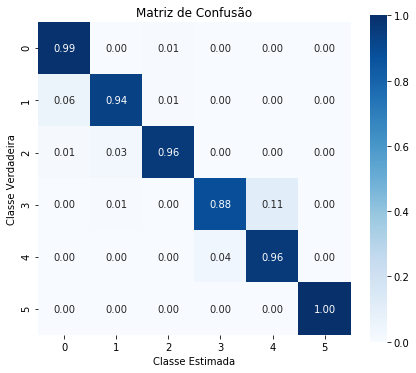

In [0]:
p_all = []
X = test_X
y = test_y

for theta in q_theta:
  p_all.append(predict(X, theta))

p = np.argmax(p_all,axis=0)
p = [classes[q] for q in p]

print("F-Score", metrics.f1_score(y,p,average='micro'))

conf_matrix = metrics.confusion_matrix(y, p)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm = sbn.heatmap(conf_matrix, fmt='.2f', square=True, annot=True, cmap="Blues")  

plt.xlabel('Classe Estimada')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()


* Para a implementação da técnica de classificação multi-classe KNN os métodos utilizados podem ser conferidos no trecho de código a seguir.

In [0]:
def distance(a, b):
  return np.linalg.norm(a-b)

def sort(d, y):
  zipped = zip(d, y)
  return sorted(zipped, key = lambda x: x[0])  

def qclass(dq, k):
  unzipped = list(zip(*dq[:k])) 
  counter = Counter(unzipped[1])
  return counter.most_common(1)[0][0]

* Na técnica kNN não há treinamento, sendo assim o algoritimo para comparação entre conjunto de treino e teste foi implementados imediatamente. 

In [0]:
test_d = []
for ts in test_X:
  d = []
  for tr in train_X:
    d.append(distance(ts, tr))
  test_d.append(sort(d, train_y))

* Foram testados de 1 a 100 vizinhos.
* Para avaliação do modelo foi selecionado o número de vizinhos que máximiza o F-score.
* O método de avaliação global é *micro-averaging*, o mesmo usado no tópico de regressão anteriormente discutido.

O número de vizinhos que máximiza o F-score é de 19. E comparando os resultados obtidos para kNN com os anteriormente obtidos para regressão, é possível perceber uma piora no valor de F-score que agora é de 0,908. 

A razão dessa piora fica evidente quando comparadas as matrizes de confusão, já que em kNN a classe 2 teve apenas 72% das amostras corretamente classficadas, assim como a classe 3 com apenas 76%. Diferentemente do caso de regressão onde o pior desempenho ficou para a classe 3, mas com apenas 11% de classificações erradas.



K vizinhos 19
F-Score 0.9083503054989817


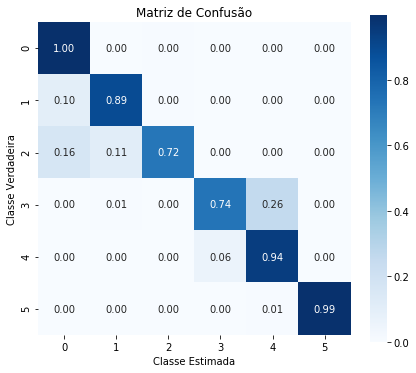

In [0]:
y = test_y
neighbors = 100
fscore_max = 0

for k in range(1, neighbors+1):
  q_test = []
  for t in test_d:
    q = qclass(t, k)
    q_test.append(q)
  fscore = metrics.f1_score(y,q_test,average='micro')
  if fscore > fscore_max:
    fscore_max = fscore
    k_max = k

print("K vizinhos", k_max)
print("F-Score", fscore_max)

conf_matrix = metrics.confusion_matrix(y, q_test)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
cm = sbn.heatmap(conf_matrix, fmt='.2f', square=True, annot=True, cmap="Blues") 

plt.xlabel('Classe Estimada')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão') 
plt.show()